# Florescent-Florescent Linear Image Registration
This notebook is adapted from https://github.com/airlab-unibas/airlab/blob/master/examples/affine_registration_3d.py

- Fixed image: DK52
- Moving image: DK43

In [1]:
import airlab as al
import numpy as np
import torch

import utility as util

## Load images

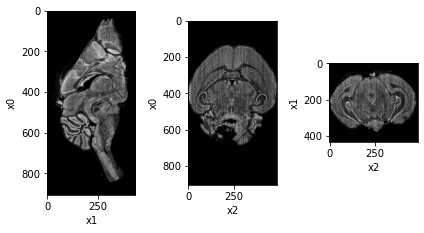

In [2]:
fixed_image = np.load('../data/ff/fixed_image.npy')
fixed_image = util.normalize_intensity(fixed_image)
util.imshow_midslice(fixed_image)

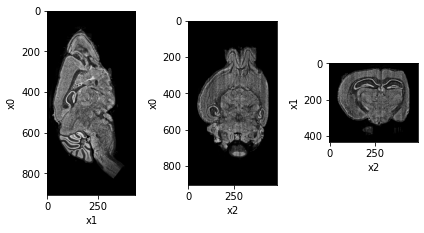

In [3]:
moving_image = np.load('../data/ff/moving_image.npy')
moving_image = util.normalize_intensity(moving_image)
util.imshow_midslice(moving_image)

## Prepare images for registration

In [4]:
dtype = torch.float32
device = torch.device('cpu')
scales = [1, 1, 1]

fixed_image = torch.tensor(fixed_image, dtype=dtype).to(device)
fixed_image = al.Image(fixed_image, fixed_image.shape, scales, [0, 0, 0])
moving_iamge = torch.tensor(moving_image, dtype=dtype).to(device)
moving_image = al.Image(moving_image, moving_image.shape, scales, [0, 0, 0])

## Prepare image pyramid

In [5]:
scales = [[4, 4, 4], [2, 2, 2]]

fixed_image_pyramid = al.create_image_pyramid(fixed_image, scales)
moving_image_pyramid = al.create_image_pyramid(moving_image, scales)

## Run registration

In [6]:
lr = 5e-3
niter = [128, 16, 2]

In [7]:
import time

start = time.time()

for level, (mov_im, fix_im) in enumerate(zip(moving_image_pyramid, fixed_image_pyramid)):
    print('level', level)
    registration = al.PairwiseRegistration(verbose=True)
    
    transformation = al.transformation.pairwise.AffineTransformation(mov_im)
    if level == 0:
        transformation.init_translation(fix_im)
    else:
        transformation.set_parameters(**parameters)
    registration.set_transformation(transformation)
    
    image_loss = al.loss.pairwise.MSE(fix_im, mov_im)
    registration.set_image_loss([image_loss])
    
    optimizer = torch.optim.Adam(transformation.parameters(), lr=lr)
    registration.set_optimizer(optimizer)
    
    registration.set_number_of_iterations(niter[level])
    registration.start()
    
    parameters = {
        't': (
            float(transformation._t_x),
            float(transformation._t_y),
            float(transformation._t_z)
        ),
        'phi': (
            float(transformation._phi_z),
            float(transformation._phi_x),
            float(transformation._phi_y),
        ),
        'scale': (
            float(transformation._scale_x),
            float(transformation._scale_y),
            float(transformation._scale_z)
        ),
        'shear': (
            float(transformation._shear_y_x),
            float(transformation._shear_x_y),
            float(transformation._shear_z_x),
            float(transformation._shear_z_y),
            float(transformation._shear_x_z),
            float(transformation._shear_y_z),
        ),
    }

end = time.time()
print((end - start) / 60, 'min')

level 0
0 

/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


mse: 0.011991318786285045 
1 

/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


mse: 0.01179810343388138 
2 mse: 0.011556815223434961 
3 mse: 0.011289170565312 
4 mse: 0.011114319181725235 
5 mse: 0.010819311395827853 
6 mse: 0.010582485125719568 
7 mse: 0.010334847566881855 
8 mse: 0.010090630640167287 
9 mse: 0.009862487837477913 
10 mse: 0.0096548351589329 
11 mse: 0.009478105906435517 
12 mse: 0.00930870205947922 
13 mse: 0.009137993138946398 
14 mse: 0.008983330337830768 
15 mse: 0.00883407582178259 
16 mse: 0.008684193963706573 
17 mse: 0.008535770892175557 
18 mse: 0.0084043843030806 
19 mse: 0.008273388738315093 
20 mse: 0.008169185946010314 
21 mse: 0.008072798369133879 
22 mse: 0.00795997205247396 
23 mse: 0.007862986875368537 
24 mse: 0.00775182431623554 
25 mse: 0.007626213454343064 
26 mse: 0.007512774286060761 
27 mse: 0.007397952482457523 
28 mse: 0.007273907239044896 
29 mse: 0.007144339882732337 
30 mse: 0.007017278542556783 
31 mse: 0.006890399625590658 
32 mse: 0.0067676943054852425 
33 mse: 0.006647814096136678 
34 mse: 0.006527419503249661 
35

## Examine results

In [8]:
transformation.print()

_phi_z 0.05692188398826513
_t_x 0.1388764639172624
_t_y -0.18395709603745994
_t_z 0.12927153944612305
_phi_x -0.2527620260659857
_phi_y -0.013340173151307859
_scale_x 0.9684591921748664
_scale_y 0.9033247306751128
_scale_z 1.063214387566368
_shear_y_x -0.06085966300520895
_shear_x_y 0.05080058918326183
_shear_z_x 0.01638720841761621
_shear_z_y 0.2395507338300403
_shear_x_z 0.012283158164051445
_shear_y_z 0.1144133128347255


In [9]:
displacement = transformation.get_displacement()
warped_image = al.transformation.utils.warp_image(moving_image, displacement)
np.save('../data/ff/moving_image_after_linear_reg.npy', warped_image.image[0,0].numpy())

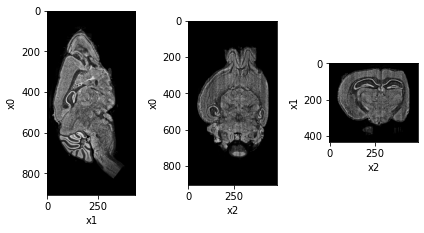

In [10]:
util.imshow_midslice(moving_image.image[0,0].numpy())

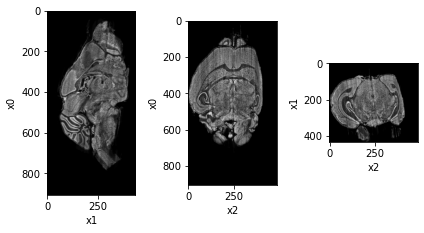

In [11]:
util.imshow_midslice(warped_image.image[0,0].numpy())

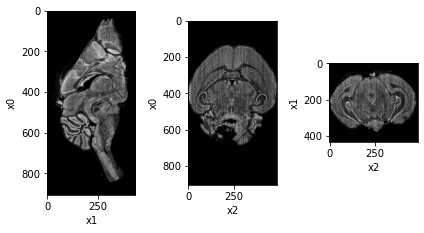

In [12]:
util.imshow_midslice(fixed_image.image[0,0].numpy())